# 1 特征工程优化

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV
from scipy import stats

# 加载已预处理的数据
df = pd.read_csv('../datasets/walmart_preprocessed.csv')

In [134]:
# 1. 基于EDA添加更有针对性的交互特征
# 只保留经验证有价值的交互特征
df['Age_City'] = df['Age'].astype(str) + "_" + df['City_Category']
df['Gender_Marital'] = df['Gender'] + "_" + df['Marital_Status'].astype(str)

# 2. 改进的RFM分析
# R(Recency)：停留年限的对数转换，更好地处理长尾分布
df['Recency_Score'] = 5 - df['Stay_Years'] 
df['Recency_Log'] = np.log1p(df['Recency_Score'])

# F(Frequency)：购买频次的分段和对数转换
df['Frequency_Score'] = pd.qcut(df['Purchase_Count'], 5, labels=[1, 2, 3, 4, 5])
df['Frequency_Log'] = np.log1p(df['Purchase_Count'])

# M(Monetary)：使用分位数而不是等距分箱，更好地处理异常值
df['Monetary_Score'] = pd.qcut(df['Total_User_Purchase'], 5, labels=[1, 2, 3, 4, 5])
df['Monetary_Log'] = np.log1p(df['Total_User_Purchase'])

# RFM分数 - 使用数值特征而非字符串连接，方便模型处理
df['RFM_Total'] = df['Recency_Score'].astype(int) + df['Frequency_Score'].astype(int) + df['Monetary_Score'].astype(int)

# 3. 处理偏态分布特征
# 对高度偏斜的数值特征应用对数转换
skewed_features = ['Product_Purchase_Var', 'Avg_Transaction_Value', 'Total_User_Purchase']
for col in skewed_features:
    if col in df.columns:
        df[f'{col}_log'] = np.log1p(df[col])

# 4. 更有针对性的特征组合
# 产品类别和用户消费水平的交互
user_spending_level = pd.qcut(df['Total_User_Purchase'], 3, labels=['低', '中', '高']).astype(str)  # 转换为字符串类型
df['Product_Spending'] = df['Product_Category'].astype(str) + "_" + user_spending_level

# 5. 特征分箱 - 将连续特征转换为分类特征
df['Occupation_Bin'] = pd.cut(df['Occupation'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# 6. 比率特征 - 捕捉相对关系
df['Purchase_Frequency_Ratio'] = df['Purchase_Count'] / (df['Stay_Years'] + 1)  # 避免除以0
df['Avg_Purchase_Ratio'] = df['Purchase'] / (df['Avg_User_Purchase'] + 1)  # 单次购买与平均的比值

# 7. 使用更高级的多项式特征 - 仅选择关键变量
df['Purchase_Count_Sq'] = df['Purchase_Count'] ** 2
df['Stay_Years_Sq'] = df['Stay_Years'] ** 2

# 8. 目标编码 - 替换原始分类特征
for cat in ['City_Category', 'Age']:
    # 使用均值编码替代原始类别
    means = df.groupby(cat)['Purchase'].mean()
    df[f'{cat}_target_mean'] = df[cat].map(means)
    # 添加方差编码，捕捉类别内部差异
    vars = df.groupby(cat)['Purchase'].var()
    df[f'{cat}_target_var'] = df[cat].map(vars)

In [135]:
# 准备最终特征集
categorical_features = [
    'Gender', 'Age', 'City_Category', 'Marital_Status', 
    'Gender_Marital', 'Age_City', 'Product_Spending', 'Occupation_Bin'
]

numerical_features = [
    'Occupation', 'Stay_Years', 'Product_Category', 'City_Code', 
    'Gender_Code', 'Total_User_Purchase', 'Purchase_Count',
    'Avg_User_Purchase', 'Avg_Category_Purchase', 
    'Monetary_Log', 'Frequency_Log', 'Recency_Log',
    'RFM_Total', 'Purchase_Frequency_Ratio', 'Avg_Purchase_Ratio',
    'City_Category_target_mean', 'Age_target_mean'
]

# 2 特征选择

In [136]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# 准备X和y
target = 'Purchase'
X = df.drop(['Purchase', 'Purchase_Log'], axis=1)
y = df[target]

# 去除不需要的列
cols_to_drop = ['User_ID', 'Product_ID', 'Stay_In_Current_City_Years', 
               'Purchase_Normalized', 'Purchase_Standardized', 'Age_Category']
X = X.drop([col for col in cols_to_drop if col in X.columns], axis=1)

In [137]:
# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
# 预处理管道
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', PowerTransformer(method='yeo-johnson'))  # 使用更适合处理偏态分布的转换器
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 构建预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [col for col in numerical_features if col in X.columns]),
        ('cat', categorical_transformer, [col for col in categorical_features if col in X.columns])
    ])

# 应用预处理
preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

In [ ]:
# 使用多种方法进行特征选择，获取更全面视角
# 1. 基于树模型的特征重要性
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selector.fit(preprocessed_X_train, y_train)

# 获取特征名称
feature_names = []
# 数值特征保留原名
feature_names.extend([col for col in numerical_features if col in X_train.columns])
# 分类特征转换为OneHot后的名称
for feature in [col for col in categorical_features if col in X_train.columns]:
    unique_values = X_train[feature].unique()
    for value in unique_values:
        feature_names.append(f"{feature}_{value}")

# 截取与特征重要性数量相同的特征名
feature_names = feature_names[:len(rf_selector.feature_importances_)]

# 创建特征重要性DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RF_Importance': rf_selector.feature_importances_
}).sort_values('RF_Importance', ascending=False)

# 显示重要特征
print("随机森林特征重要性排名前20:")
print(importance_df.head(20))

In [ ]:
# 2. Lasso基础特征选择
lasso = Lasso(alpha=0.01)
sfm = SelectFromModel(lasso, threshold=0.01)
sfm.fit(preprocessed_X_train, y_train)
selected_idx = sfm.get_support()

# 显示Lasso选择的特征
selected_features = [feature_names[i] for i in range(len(selected_idx)) if selected_idx[i]]
print("\nLasso选择的特征:")
print(selected_features)

In [ ]:
# 3. 互信息特征选择 - 捕捉非线性关系
k_best = min(30, preprocessed_X_train.shape[1])
selector = SelectKBest(score_func=mutual_info_regression, k=k_best)
X_new = selector.fit_transform(preprocessed_X_train, y_train)
selected_mi_idx = selector.get_support()

# 显示互信息选择的特征
mi_selected_features = [feature_names[i] for i in range(len(selected_mi_idx)) if selected_mi_idx[i]]
print("\n基于互信息选择的前30个特征:")
print(mi_selected_features)

In [ ]:
# 4. 递归特征消除(RFE)
estimator = RandomForestRegressor(n_estimators=50, random_state=42)
rfecv = RFECV(
    estimator=estimator, 
    step=1, 
    cv=5,
    scoring='neg_mean_squared_error',
    min_features_to_select=10
)

# 使用样本数据进行RFECV以提高效率
sample_size = min(10000, preprocessed_X_train.shape[0])
indices = np.random.choice(preprocessed_X_train.shape[0], sample_size, replace=False)
rfecv.fit(preprocessed_X_train[indices], y_train.iloc[indices])

In [ ]:
# 绘制RFECV结果
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('特征数量')
plt.ylabel('交叉验证得分')
plt.title('递归特征消除的最优特征数量')
plt.tight_layout()
plt.savefig('../outputs/visualization/feature_selection/rfecv_results.png')

rfe_selected_features = [feature_names[i] for i in range(len(rfecv.support_)) if rfecv.support_[i]]
print(f"\n递归特征消除选择的{len(rfe_selected_features)}个特征:")
print(rfe_selected_features)

In [ ]:
# 整合特征选择结果，选择多数方法认可的特征
# 将各种方法选择的特征索引整合
selected_by_rf = set([i for i in range(len(rf_selector.feature_importances_)) 
                     if rf_selector.feature_importances_[i] > np.percentile(rf_selector.feature_importances_, 70)])
selected_by_lasso = set([i for i in range(len(selected_idx)) if selected_idx[i]])
selected_by_mi = set([i for i in range(len(selected_mi_idx)) if selected_mi_idx[i]])
selected_by_rfe = set([i for i in range(len(rfecv.support_)) if rfecv.support_[i]])

# 统计每个特征被选中的次数
feature_votes = {}
for i in range(len(feature_names)):
    votes = 0
    if i in selected_by_rf: votes += 1
    if i in selected_by_lasso: votes += 1
    if i in selected_by_mi: votes += 1
    if i in selected_by_rfe: votes += 1
    feature_votes[feature_names[i]] = votes

# 选择被至少两种方法认可的特征
final_selected_features = [feature for feature, votes in feature_votes.items() if votes >= 2]
print(f"\n最终选择的{len(final_selected_features)}个特征:")
print(final_selected_features)

In [ ]:
# 可视化每个特征被选择的次数
feat_votes_df = pd.DataFrame({
    'Feature': list(feature_votes.keys()),
    'Votes': list(feature_votes.values())
}).sort_values('Votes', ascending=False).head(30)

plt.figure(figsize=(12, 8))
plt.bar(feat_votes_df['Feature'], feat_votes_df['Votes'])
plt.xticks(rotation=90)
plt.xlabel('特征')
plt.ylabel('被选择的方法数')
plt.title('Top 30特征的综合评分')
plt.tight_layout()
plt.savefig('../outputs/visualization/feature_selection/feature_votes.png')

In [ ]:
# 应用PCA降维来处理共线性
pca = PCA(n_components=0.95)  # 保留95%方差
X_pca = pca.fit_transform(preprocessed_X_train)
print(f"\nPCA降维后的特征数量: {X_pca.shape[1]}")
print(f"累计解释方差比: {pca.explained_variance_ratio_.cumsum()[-1]:.4f}")

# 可视化PCA结果
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('主成分数量')
plt.ylabel('累计解释方差比')
plt.title('PCA累计解释方差')
plt.grid(True)
plt.tight_layout()
plt.savefig('../outputs/visualization/feature_selection/pca_variance.png')

# 3 基础模型构建与训练

In [ ]:
# 导入sklearn相关
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# 导入XGBoost
import xgboost as xgb

# 导入LightGBM
import lightgbm as lgb

## 3.1 构建

In [12]:
# 构建基础模型
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)),
    ('gbm', GradientBoostingRegressor(n_estimators=50, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=50, n_jobs=-1, random_state=42)),
    ('lgbm', lgb.LGBMRegressor(n_estimators=50, n_jobs=-1, random_state=42))
]

In [13]:
import time
# 动态确定样本大小
total_size = len(X_train)
print(f"训练集总大小: {total_size}行")

# 根据数据集大小自动确定样本大小
if total_size < 5000:
    # 如果数据集很小，使用全部数据
    sample_size = total_size
    print(f"数据集较小，使用全部{sample_size}个样本")
elif total_size < 50000:
    # 中等大小数据集，使用20%或5000个样本(取较大值)
    sample_size = max(int(total_size * 0.2), 5000)
    print(f"数据集中等大小，使用{sample_size}个样本(约{sample_size/total_size*100:.1f}%的数据)")
else:
    # 大型数据集，使用10%或10000个样本(取较大值)
    sample_size = max(int(total_size * 0.1), 10000)
    print(f"数据集较大，使用{sample_size}个样本(约{sample_size/total_size*100:.1f}%的数据)")

训练集总大小: 440054行
数据集较大，使用44005个样本(约10.0%的数据)


## 3.2 训练

In [14]:
# 如果有足够的样本，则取样本进行训练
if sample_size < total_size:
    sample_indices = np.random.choice(total_size, sample_size, replace=False)
    sample_X_train = preprocessed_X_train[sample_indices]
    sample_y_train = y_train.iloc[sample_indices]
    
    print(f"从{total_size}行数据中抽取{sample_size}行用于快速模型评估")
    
    # 使用样本数据训练模型
    for name, model in base_models:
        start_time = time.time()
        model.fit(sample_X_train, sample_y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(preprocessed_X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        print(f"{name} (样本训练) - R²: {r2:.4f}, RMSE: {rmse:.2f}, 训练时间: {train_time:.2f}秒")
else:
    # 数据集很小，使用全部数据
    print("数据集较小，使用全部数据进行训练")
    
    for name, model in base_models:
        start_time = time.time()
        model.fit(preprocessed_X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict(preprocessed_X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.2f}, 训练时间: {train_time:.2f}秒")

从440054行数据中抽取44005行用于快速模型评估
rf (样本训练) - R²: 0.6242, RMSE: 3072.93, 训练时间: 18.27秒
gbm (样本训练) - R²: 0.6709, RMSE: 2875.68, 训练时间: 4.88秒
xgb (样本训练) - R²: 0.6704, RMSE: 2877.75, 训练时间: 0.25秒
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1469
[LightGBM] [Info] Number of data points in the train set: 44005, number of used features: 141
[LightGBM] [Info] Start training from score 9283.831496
lgbm (样本训练) - R²: 0.6734, RMSE: 2864.79, 训练时间: 0.14秒


# 4 LightGBM模型

## 4.1 LightGBM模型初始化与训练

In [15]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("初始化LightGBM模型...")

# 创建LightGBM管道
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(random_state=42, n_jobs=-1))
])

初始化LightGBM模型...


## 4.2 调参

In [16]:
# LightGBM参数网格
param_grid = {
    'model__n_estimators': [100, 200, 400, 600],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [5, 7, 9, -1],  # -1表示无限制
    'model__num_leaves': [31, 63, 127],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0]
}

In [17]:
# 使用RandomizedSearchCV减少计算量
random_search = RandomizedSearchCV(
    lgbm_pipeline, 
    param_distributions=param_grid, 
    n_iter=20,  # 随机尝试20种组合
    cv=5,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [18]:
# 训练模式选择 - 视数据集大小而定
if len(X_train) > 50000:
    # 大数据集，使用样本数据
    sample_size = min(30000, int(len(X_train) * 0.3))
    sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_train_sample = X_train.iloc[sample_indices]
    y_train_sample = y_train.iloc[sample_indices]
    
    print(f"在{sample_size}条样本上进行参数搜索(总数据{len(X_train)}条)...")
    random_search.fit(X_train_sample, y_train_sample)
else:
    # 小型数据集，使用全部数据
    print(f"在全部{len(X_train)}条数据上进行参数搜索...")
    random_search.fit(X_train, y_train)

print("最佳参数:")
print(random_search.best_params_)

在30000条样本上进行参数搜索(总数据440054条)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 140
[LightGBM] [Info] Start training from score 9256.113500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
最佳参数:
{'model__subsample': 1.0, 'model__num_leaves': 31, 'model__n_estimators': 600, 'model__max_depth': 7, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}


## 4.3 最终模型

In [28]:
# 获取最佳LightGBM模型参数
best_lgbm_params = {
    'n_estimators': random_search.best_params_['model__n_estimators'],
    'learning_rate': random_search.best_params_['model__learning_rate'],
    'max_depth': random_search.best_params_['model__max_depth'],
    'num_leaves': random_search.best_params_['model__num_leaves'],
    'subsample': random_search.best_params_['model__subsample'] 
        if 'model__subsample' in random_search.best_params_ else 1.0,
    'colsample_bytree': random_search.best_params_['model__colsample_bytree'] 
        if 'model__colsample_bytree' in random_search.best_params_ else 1.0,
    'random_state': 42
}

In [29]:
print("最终使用的LightGBM参数:")
for param, value in best_lgbm_params.items():
    print(f"  {param}: {value}")

# 使用100,000样本训练最终模型
final_sample_size = 100000
print(f"\n使用{final_sample_size}条样本训练最终模型(总数据{len(X_train)}条)...")

# 随机选择100,000个样本
final_sample_indices = np.random.choice(len(X_train), final_sample_size, replace=False)
X_train_final_sample = X_train.iloc[final_sample_indices]
y_train_final_sample = y_train.iloc[final_sample_indices]

最终使用的LightGBM参数:
  n_estimators: 600
  learning_rate: 0.01
  max_depth: 7
  num_leaves: 31
  subsample: 1.0
  colsample_bytree: 0.8
  random_state: 42

使用100000条样本训练最终模型(总数据440054条)...


In [30]:
# 创建最终LightGBM模型
best_lgbm = lgb.LGBMRegressor(**best_lgbm_params, n_jobs=-1)

# 创建完整管道
final_lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_lgbm)
])

In [31]:
# 训练最终模型并记录时间
start_time = time.time()
final_lgbm_pipeline.fit(X_train_final_sample, y_train_final_sample)
train_time = time.time() - start_time

print(f"最终模型训练完成，耗时: {train_time:.2f}秒")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 143
[LightGBM] [Info] Start training from score 9288.366840
最终模型训练完成，耗时: 1.83秒


## 4.4 保存模型与参数字典

In [ ]:
import pickle
import joblib
import os

# 创建保存模型的目录（如果不存在）
os.makedirs('../models', exist_ok=True)
os.makedirs('../models/lgbm', exist_ok=True)

In [93]:
joblib.dump(final_lgbm_pipeline, '../models/lgbm/final_lgbm_pipeline.joblib')

# 保存参数字典
with open('../models/lgbm/best_lgbm_params.pkl', 'wb') as f:
    pickle.dump(best_lgbm_params, f)

In [87]:
import json
import datetime
# 保存训练信息
model_info = {
    'sample_size': final_sample_size,
    'total_data_size': len(X_train),
    'train_time': train_time,
    'parameters': best_lgbm_params,
    'training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('../models/lgbm/lgbm_model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

## 4.5 测试集训练

In [37]:
# 在测试集上评估模型
y_pred_lgbm = final_lgbm_pipeline.predict(X_test)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print(f"最终LightGBM模型评估结果:")
print(f"  R²: {r2_lgbm:.4f}")
print(f"  RMSE: {rmse_lgbm:.2f}")
print(f"  MAE: {mae_lgbm:.2f}")

最终LightGBM模型评估结果:
  R²: 0.6758
  RMSE: 2854.26
  MAE: 2104.64


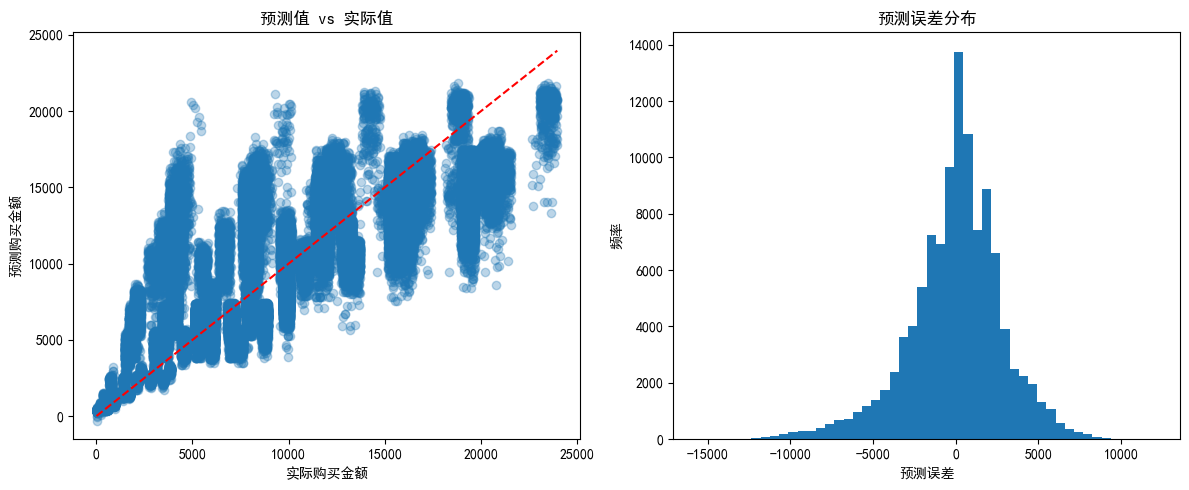

In [89]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['font.family'] = 'SimHei'  # 或其他支持中文的字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

# 创建评估结果可视化
plt.figure(figsize=(12, 5))

# 预测值与实际值散点图
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lgbm, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('实际购买金额')
plt.ylabel('预测购买金额')
plt.title('预测值 vs 实际值')

# 误差分布直方图
plt.subplot(1, 2, 2)
errors = y_test - y_pred_lgbm
plt.hist(errors, bins=50)
plt.xlabel('预测误差')
plt.ylabel('频率')
plt.title('预测误差分布')

plt.tight_layout()
plt.savefig('../outputs/visualization/lgbm/model_evaluation.png')
plt.show()

In [91]:
# 在测试集上评估LightGBM特征重要性
if hasattr(best_lgbm, 'feature_importances_'):
    # 提取预处理后的特征名称
    feature_names = []
    
    # 获取数值型特征
    num_features = [col for col in numerical_features if col in X_train.columns]
    feature_names.extend(num_features)
    
    # 获取分类特征（经过独热编码）
    cat_features = [col for col in categorical_features if col in X_train.columns]
    for feature in cat_features:
        unique_values = X_train[feature].unique()
        for value in unique_values:
            feature_names.append(f"{feature}_{value}")
    
    # 确保特征名和特征重要性数量匹配（取较小值）
    n_features = min(len(feature_names), len(best_lgbm.feature_importances_))
    
    # 创建特征重要性DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names[:n_features],
        'Importance': best_lgbm.feature_importances_[:n_features]
    }).sort_values('Importance', ascending=False)
    
    # 显示前20个最重要特征
    print("\n前20个最重要特征:")
    print(feature_importance.head(20))
    
    # 可视化特征重要性
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('LightGBM - 前20个特征重要性')
    plt.tight_layout()
    plt.savefig('../outputs/visualization/lgbm/feature_importance_lgbm.png')
    plt.show()
    
    # 保存特征重要性数据
    feature_importance.to_csv('../outputs/lgbm/feature_importance.csv', index=False)
    print("特征重要性已保存到 '../outputs/lgbm/feature_importance.csv'")

# 5 Ridge模型优化

## 5.1 Ridge模型参数调优

In [110]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import time

# 定义Ridge模型和参数空间
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 100.0],
    'solver': ['auto', 'lsqr', 'sparse_cg', 'sag'],  # 只使用支持稀疏数据的求解器
    'fit_intercept': [False, True],  # 当使用合适的求解器时，True也可以工作
    'max_iter': [1000],
    'tol': [0.001, 0.0001]
}

In [111]:
# 考虑到参数组合较多，使用RandomizedSearchCV更高效
ridge_model = Ridge(random_state=42)

# 使用随机搜索更高效
ridge_random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=ridge_param_grid,
    n_iter=20,  # 随机尝试20种组合
    scoring='r2',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [112]:
# 在与LightGBM相同数量的训练集样本上执行搜索
print(f"\n使用{final_sample_size}条样本执行Ridge参数搜索...")
start_time = time.time()
ridge_random_search.fit(preprocessed_X_train[final_sample_indices], y_train_final_sample)
search_time = time.time() - start_time

print(f"参数搜索完成，耗时: {search_time:.2f}秒")
print("Ridge最佳参数:", ridge_random_search.best_params_)
print("Ridge最佳分数(R²):", ridge_random_search.best_score_)


使用100000条样本执行Ridge参数搜索...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
参数搜索完成，耗时: 10.34秒
Ridge最佳参数: {'tol': 0.0001, 'solver': 'sag', 'max_iter': 1000, 'fit_intercept': True, 'alpha': 0.1}
Ridge最佳分数(R²): 0.6746449649716506


## 5.2 使用最佳参数训练Ridge模型

In [113]:
best_ridge = ridge_random_search.best_estimator_

# 创建完整的Ridge模型管道
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_ridge)
])

# 训练最终Ridge模型
print("\n使用最佳参数在训练集样本上训练Ridge模型...")
start_time = time.time()
ridge_pipeline.fit(X_train_final_sample, y_train_final_sample)
ridge_train_time = time.time() - start_time
print(f"Ridge模型训练完成，耗时: {ridge_train_time:.2f}秒")


使用最佳参数在训练集样本上训练Ridge模型...
Ridge模型训练完成，耗时: 0.92秒


## 5.3 评估Ridge模型

In [114]:
print("\n在测试集上评估Ridge模型...")
y_pred_ridge = ridge_pipeline.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print("Ridge模型评估结果:")
print(f"  R²: {r2_ridge:.4f}")
print(f"  RMSE: {rmse_ridge:.2f}")
print(f"  MAE: {mae_ridge:.2f}")


在测试集上评估Ridge模型...
Ridge模型评估结果:
  R²: 0.6667
  RMSE: 2893.87
  MAE: 2157.22


## 5.4 Ridge模型可视化

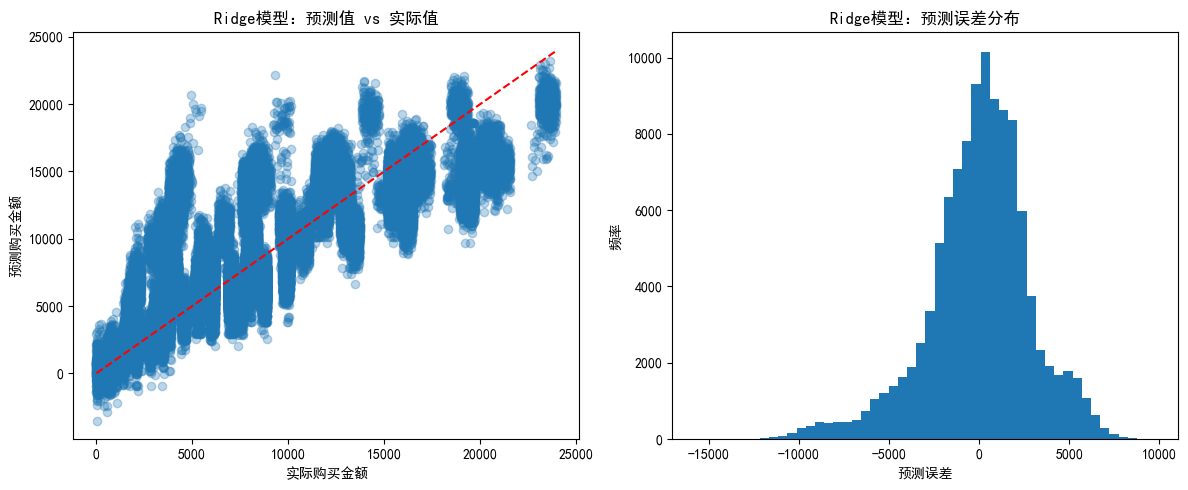

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# 创建Ridge模型评估结果可视化
plt.figure(figsize=(12, 5))

# 预测值与实际值散点图
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('实际购买金额')
plt.ylabel('预测购买金额')
plt.title('Ridge模型：预测值 vs 实际值')

# 误差分布直方图
plt.subplot(1, 2, 2)
errors_ridge = y_test - y_pred_ridge
plt.hist(errors_ridge, bins=50)
plt.xlabel('预测误差')
plt.ylabel('频率')
plt.title('Ridge模型：预测误差分布')

plt.tight_layout()
os.makedirs('../outputs/visualization/ridge', exist_ok=True)
plt.savefig('../outputs/visualization/ridge/model_evaluation.png')
plt.show()

## 5.5 保存Ridge模型

In [116]:
os.makedirs('../models/ridge', exist_ok=True)
joblib.dump(ridge_pipeline, '../models/ridge/ridge_pipeline.joblib')

# 保存参数字典 - 更新移除normalize参数
ridge_params = {
    'alpha': best_ridge.alpha,
    'solver': best_ridge.solver,
    'fit_intercept': best_ridge.fit_intercept,
    'max_iter': best_ridge.max_iter,
    'tol': best_ridge.tol,
    'random_state': 42
}

with open('../models/ridge/best_ridge_params.pkl', 'wb') as f:
    pickle.dump(ridge_params, f)

# 保存训练信息
ridge_info = {
    'sample_size': final_sample_size,
    'total_data_size': len(X_train),
    'train_time': ridge_train_time,
    'parameters': ridge_params,
    'training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('../models/ridge/ridge_model_info.json', 'w') as f:
    json.dump(ridge_info, f, indent=4)

print("Ridge模型已保存到 '../models/ridge/ridge_pipeline.joblib'")

Ridge模型已保存到 '../models/ridge/ridge_pipeline.joblib'


## 5.6 对比Ridge、LightGBM和Stacking模型

模型效果对比:
        指标        Ridge     LightGBM
0       R²     0.666703     0.675764
1     RMSE  2893.867851  2854.261275
2      MAE  2157.220844  2104.643023
3  训练时间(秒)     0.917074     1.826492


C:\Users\avawa\AppData\Local\Temp\ipykernel_28872\1296068059.py:55: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.tight_layout()
C:\Users\avawa\AppData\Local\Temp\ipykernel_28872\1296068059.py:56: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.savefig('../outputs/visualization/ridge/model_comparison.png')
c:\Users\avawa\.conda\envs\mixrec\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


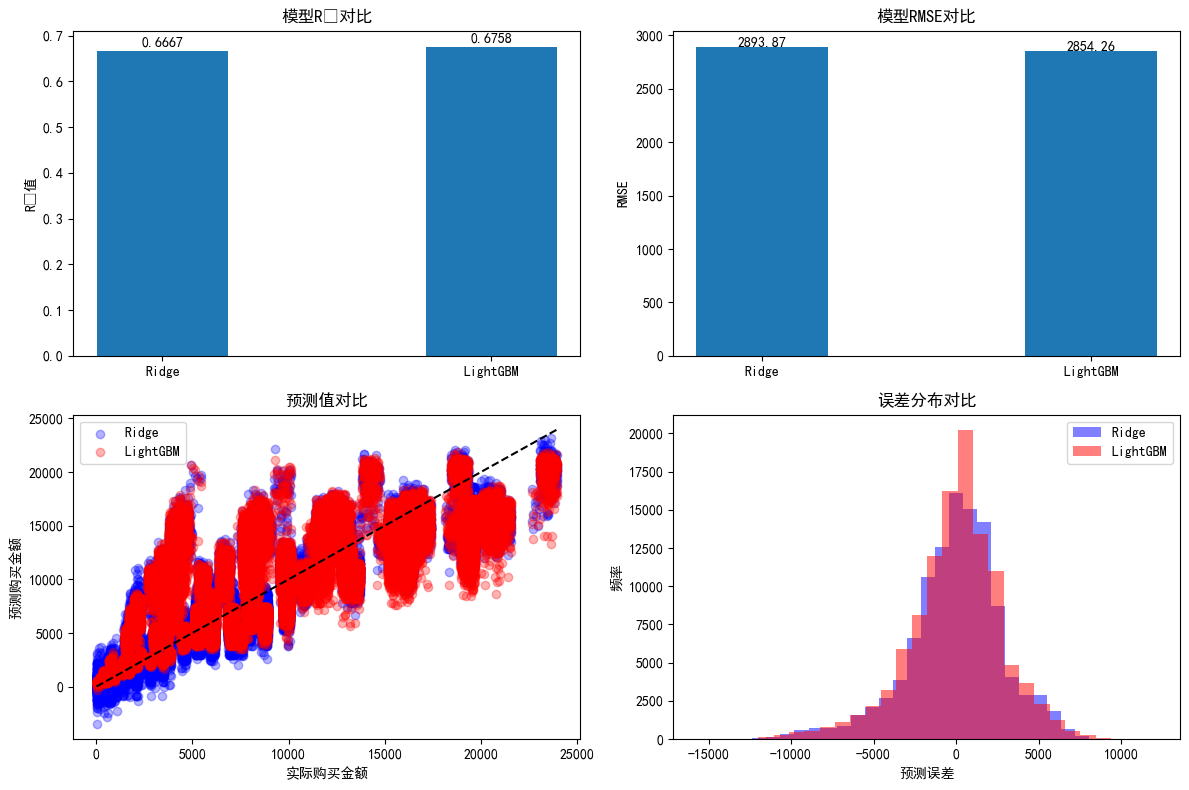

模型比较结果已保存到 '../outputs/ridge/model_comparison.csv'


In [118]:
# 创建总结表格
model_comparison = pd.DataFrame({
    '指标': ['R²', 'RMSE', 'MAE', '训练时间(秒)'],
    'Ridge': [r2_ridge, rmse_ridge, mae_ridge, ridge_train_time],
    'LightGBM': [r2_lgbm, rmse_lgbm, mae_lgbm, train_time]
})

print("模型效果对比:")
print(model_comparison)

# 创建模型比较可视化
plt.figure(figsize=(12, 8))

# R²对比条形图
plt.subplot(2, 2, 1)
models = ['Ridge', 'LightGBM']
r2_values = [r2_ridge, r2_lgbm]
x = range(len(models))
plt.bar(x, r2_values, width=0.4)
plt.xticks(x, models)
plt.ylabel('R²值')
plt.title('模型R²对比')
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# RMSE对比条形图
plt.subplot(2, 2, 2)
rmse_values = [rmse_ridge, rmse_lgbm]
plt.bar(x, rmse_values, width=0.4)
plt.xticks(x, models)
plt.ylabel('RMSE')
plt.title('模型RMSE对比')
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

# 散点图对比
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_ridge, alpha=0.3, color='blue', label='Ridge')
plt.scatter(y_test, y_pred_lgbm, alpha=0.3, color='red', label='LightGBM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('实际购买金额')
plt.ylabel('预测购买金额')
plt.title('预测值对比')
plt.legend()

# 误差分布对比
plt.subplot(2, 2, 4)
plt.hist(errors_ridge, bins=30, alpha=0.5, color='blue', label='Ridge')
plt.hist(y_test - y_pred_lgbm, bins=30, alpha=0.5, color='red', label='LightGBM')
plt.xlabel('预测误差')
plt.ylabel('频率')
plt.title('误差分布对比')
plt.legend()

plt.tight_layout()
plt.savefig('../outputs/visualization/ridge/model_comparison.png')
plt.show()

# 保存模型比较结果
os.makedirs('../outputs/ridge', exist_ok=True)
model_comparison.to_csv('../outputs/ridge/model_comparison.csv', index=False)
print("模型比较结果已保存到 '../outputs/ridge/model_comparison.csv'")

# 6 Stacking集成模型

## 6.1 准备基础模型

In [119]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.svm import SVR

# 创建三个独立的基础模型，以避免共享数据处理管道
best_lgbm = lgb.LGBMRegressor(**best_lgbm_params, n_jobs=-1)

# 使用已经优化过的Ridge模型参数
best_ridge_params = {
    'alpha': best_ridge.alpha,
    'fit_intercept': best_ridge.fit_intercept,
    'solver': best_ridge.solver,
    'max_iter': best_ridge.max_iter,
    'tol': best_ridge.tol,
    'random_state': 42
}
ridge_model = Ridge(**best_ridge_params)

gbm_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [120]:
# 定义基础模型列表
base_estimators = [
    ('lgbm', best_lgbm),
    ('gbm', gbm_model),
    ('xgb', xgb_model),
    ('ridge', ridge_model)  # 添加一个线性模型以增加多样性
]

print("已选择以下基础模型用于Stacking:")
for name, _ in base_estimators:
    print(f"- {name}")

已选择以下基础模型用于Stacking:
- lgbm
- gbm
- xgb
- ridge


## 6.2 构建Stacking模型

In [123]:
from sklearn.ensemble import GradientBoostingRegressor
# 使用梯度提升树作为元模型
final_estimator = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

# 创建StackingRegressor
stacking_regressor = StackingRegressor(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 使用所有CPU核心
)

# 创建完整的Stacking模型管道
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', stacking_regressor)
])

## 6.3 训练Stacking模型

In [124]:
# 使用与LightGBM相同的100,000样本进行训练
print(f"使用{final_sample_size}条样本训练Stacking模型(总数据{len(X_train)}条)...")

# 训练Stacking模型并记录时间
start_time = time.time()
stacking_pipeline.fit(X_train_final_sample, y_train_final_sample)
stacking_train_time = time.time() - start_time

print(f"Stacking模型训练完成，耗时: {stacking_train_time:.2f}秒")

使用100000条样本训练Stacking模型(总数据440054条)...
Stacking模型训练完成，耗时: 181.93秒


## 6.4 保存Stacking模型

In [125]:
# 保存完整的Stacking管道
joblib.dump(stacking_pipeline, '../models/stacking/stacking_pipeline.joblib')

# 保存训练信息
stacking_info = {
    'sample_size': final_sample_size,
    'total_data_size': len(X_train),
    'train_time': stacking_train_time,
    'base_models': [est[0] for est in base_estimators],
    'final_estimator': 'Ridge',
    'cross_validation': 5,
    'training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('../models/stacking_model_info.json', 'w') as f:
    json.dump(stacking_info, f, indent=4)

print("Stacking模型已保存到 '../models/stacking/stacking_pipeline.joblib'")
print("模型训练信息已保存到 '../models/stacking/stacking_model_info.json'")

Stacking模型已保存到 '../models/stacking/stacking_pipeline.joblib'
模型训练信息已保存到 '../models/stacking/stacking_model_info.json'


## 6.5 评估Stacking模型

In [126]:
# 在测试集上评估Stacking模型
y_pred_stack = stacking_pipeline.predict(X_test)
r2_stack = r2_score(y_test, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mae_stack = mean_absolute_error(y_test, y_pred_stack)

In [127]:
print(f"Stacking集成模型评估结果:")
print(f"  R²: {r2_stack:.4f}")
print(f"  RMSE: {rmse_stack:.2f}")
print(f"  MAE: {mae_stack:.2f}")

Stacking集成模型评估结果:
  R²: 0.6768
  RMSE: 2849.52
  MAE: 2100.47


In [128]:
# 比较Stacking与单一LightGBM模型
print("\n与LightGBM模型比较:")
print(f"  Stacking R²: {r2_stack:.4f}，LightGBM R²: {r2_lgbm:.4f}")
print(f"  R²提升: {r2_stack - r2_lgbm:.4f} ({(r2_stack - r2_lgbm) / r2_lgbm * 100:.2f}%)")
print(f"  RMSE提升: {rmse_lgbm - rmse_stack:.2f} ({(rmse_lgbm - rmse_stack) / rmse_lgbm * 100:.2f}%)")


与LightGBM模型比较:
  Stacking R²: 0.6768，LightGBM R²: 0.6758
  R²提升: 0.0011 (0.16%)
  RMSE提升: 4.74 (0.17%)


## 6.6 可视化模型对比

C:\Users\avawa\AppData\Local\Temp\ipykernel_28872\1122116609.py:41: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.tight_layout()
C:\Users\avawa\AppData\Local\Temp\ipykernel_28872\1122116609.py:42: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.savefig('../outputs/visualization/stacking/model_comparison.png')
c:\Users\avawa\.conda\envs\mixrec\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


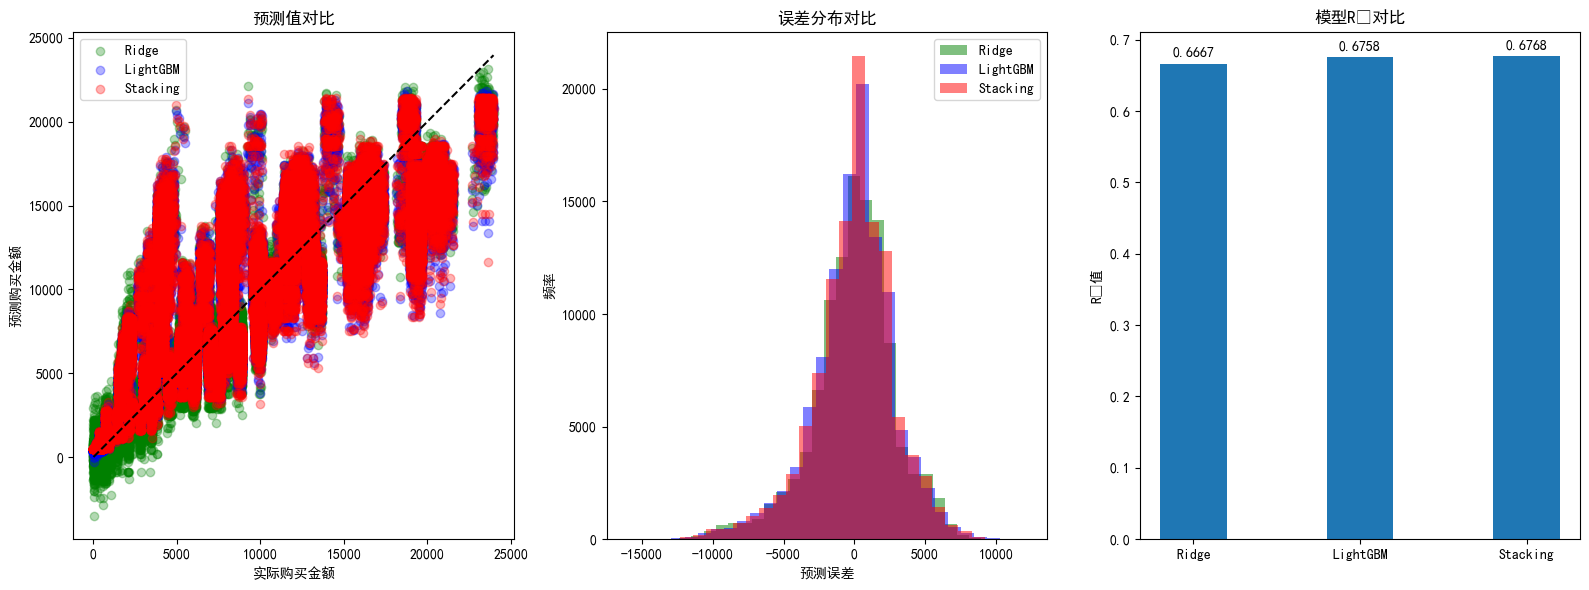

In [129]:
# 创建模型比较可视化
plt.figure(figsize=(16, 6))

# 散点图对比
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.3, color='green', label='Ridge')
plt.scatter(y_test, y_pred_lgbm, alpha=0.3, color='blue', label='LightGBM')
plt.scatter(y_test, y_pred_stack, alpha=0.3, color='red', label='Stacking')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('实际购买金额')
plt.ylabel('预测购买金额')
plt.title('预测值对比')
plt.legend()

# 误差分布对比
plt.subplot(1, 3, 2)
errors_ridge = y_test - y_pred_ridge
errors_lgbm = y_test - y_pred_lgbm
errors_stack = y_test - y_pred_stack
plt.hist(errors_ridge, bins=30, alpha=0.5, color='green', label='Ridge')
plt.hist(errors_lgbm, bins=30, alpha=0.5, color='blue', label='LightGBM')
plt.hist(errors_stack, bins=30, alpha=0.5, color='red', label='Stacking')
plt.xlabel('预测误差')
plt.ylabel('频率')
plt.title('误差分布对比')
plt.legend()

# R²对比条形图
plt.subplot(1, 3, 3)
models = ['Ridge', 'LightGBM', 'Stacking']
r2_values = [r2_ridge, r2_lgbm, r2_stack]
x = range(len(models))
plt.bar(x, r2_values, width=0.4)
plt.xticks(x, models)
plt.ylabel('R²值')
plt.title('模型R²对比')

for i, v in enumerate(r2_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig('../outputs/visualization/stacking/model_comparison.png')
plt.show()

In [130]:
# 保存模型比较结果
comparison_results = pd.DataFrame({
    'Model': ['LightGBM', 'Stacking'],
    'R2': [r2_lgbm, r2_stack],
    'RMSE': [rmse_lgbm, rmse_stack],
    'MAE': [mae_lgbm, mae_stack]
})

comparison_results.to_csv('../outputs/stacking/model_comparison.csv', index=False)
print(f"模型比较结果已保存到 '../outputs/stacking/model_comparison.csv'")

模型比较结果已保存到 '../outputs/stacking/model_comparison.csv'


## 6.7 分析组合权重

Stacking元模型中各基础模型的重要性:
  lgbm: 0.2047
  gbm: 0.2097
  xgb: 0.5523
  ridge: 0.0333


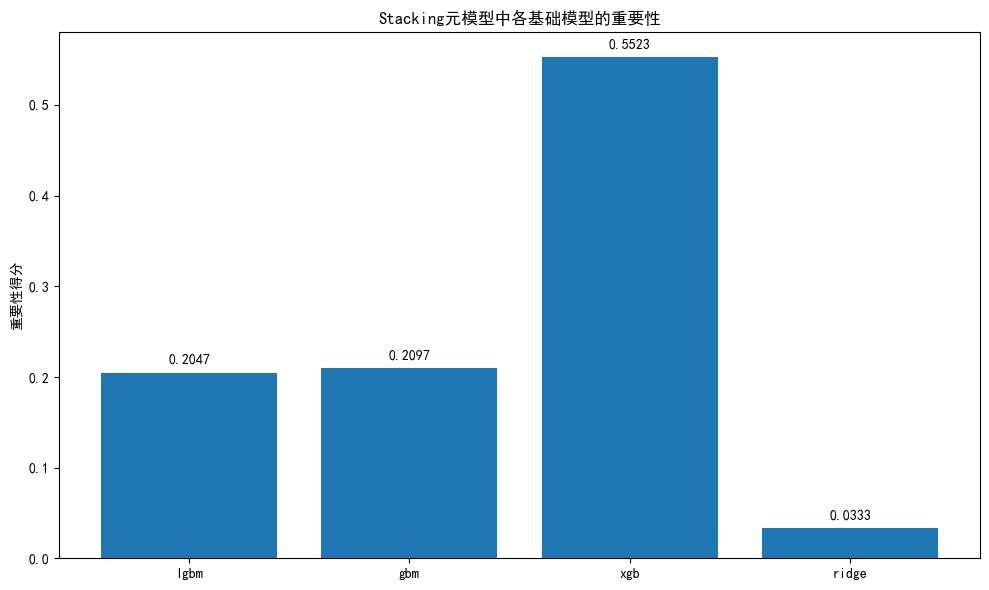

In [131]:
if hasattr(stacking_pipeline.named_steps['stacking'].final_estimator_, 'feature_importances_'):
    meta_importance = stacking_pipeline.named_steps['stacking'].final_estimator_.feature_importances_
    
    print("Stacking元模型中各基础模型的重要性:")
    for i, (name, _) in enumerate(base_estimators):
        print(f"  {name}: {meta_importance[i]:.4f}")
    
    # 创建重要性可视化
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(base_estimators)), meta_importance)
    plt.xticks(range(len(base_estimators)), [name for name, _ in base_estimators])
    plt.ylabel('重要性得分')
    plt.title('Stacking元模型中各基础模型的重要性')
    
    for i, v in enumerate(meta_importance):
        plt.text(i, v + 0.01 if v >= 0 else v - 0.05, f"{v:.4f}", ha='center')
    
    plt.tight_layout()
    plt.savefig('../outputs/visualization/stacking/stacking_importance.png')
    plt.show()

## 6.8 总结模型效果

In [132]:
# 创建总结表格
summary = pd.DataFrame({
    '指标': ['R²', 'RMSE', 'MAE', '训练时间(秒)', '样本数量'],
    'Ridge': [r2_ridge, rmse_ridge, mae_ridge, ridge_train_time, final_sample_size],
    'LightGBM': [r2_lgbm, rmse_lgbm, mae_lgbm, train_time, final_sample_size],
    'Stacking': [r2_stack, rmse_stack, mae_stack, stacking_train_time, final_sample_size]
})

# 添加提升百分比（相对于Ridge模型）
summary['相对Ridge提升'] = [
    f"{(r2_lgbm - r2_ridge) / r2_ridge * 100:.2f}%",
    f"{(rmse_ridge - rmse_lgbm) / rmse_ridge * 100:.2f}%",
    f"{(mae_ridge - mae_lgbm) / mae_ridge * 100:.2f}%",
    "NA",
    "NA"
]

# 添加提升百分比（相对于LightGBM）
summary['相对LightGBM提升'] = [
    f"{(r2_stack - r2_lgbm) / r2_lgbm * 100:.2f}%",
    f"{(rmse_lgbm - rmse_stack) / rmse_lgbm * 100:.2f}%",
    f"{(mae_lgbm - mae_stack) / mae_lgbm * 100:.2f}%",
    "NA",
    "NA"
]